Tutorial
============================

[Go to the Download page to download this notebook](https://ross-rotordynamics.github.io/ross-website/download.html)

This is a basic tutorial on how to use ROSS (rotordynamics open-source software), a Python library for rotordynamic analysis. Most of this code follows object-oriented paradigm, which is represented in this 
[UML DIAGRAM](https://user-images.githubusercontent.com/32821252/50386686-131c5200-06d3-11e9-9806-f5746295be81.png).  
In the following topics, we will discuss the most relevant classes for a quick start on how to use ROSS.

In [1]:
import ross as rs
from bokeh.io import output_notebook, show
import numpy as np
import matplotlib.pyplot as plt

output_notebook()

Loading BokehJS ...

## Materials

There is a class called Material to hold material's properties, where:

```text
name : str
    Material name.
E : float
    Young's modulus (N/m**2).
G_s : float
    Shear modulus (N/m**2).
rho : float
    Density (N/m**3).
```

Note that, to instatiate a Material class, you only need to give 2 out of the following parameters: 'E', 'G_s' ,'Poisson'.

In [2]:
steel = rs.Material(name="Steel", rho=7810, E=211e9, G_s=81.2e9)

### Saving a Material

To save an already instantiated Material object, you need to use the following method.

In [3]:
steel.save_material()

### Loading a Material


To load a material, first of all, use the available_materials() method to check if your material is available in the database, then you should use the Material.use_material('name') method with the name of the material as a parameter.



In [4]:
rs.Material.available_materials()

['Steel', 'AISI4140', 'A216WCB']

In [5]:
steel = rs.Material.use_material('Steel')

## ShaftElement

There are some ways in which you can choose the parameters to model this element:

- Euler–Bernoulli beam Theory (`rotary_inertia=False, shear_effects=False`)
- Timoshenko beam Theory (`rotary_inertia=True, shear_effects=True` - used as default)

This Element represents the rotor's shaft, all the other elements are correlated with this one.
This class can be instantiated as the code that follows.
Where (as per the documentation):

```text
L : float
    Element length.
i_d : float
    Inner diameter of the element.
o_d : float
    Outer diameter of the element.
material : ross.material
    Shaft material.
n : int, optional
    Element number (coincident with it's first node).
    If not given, it will be set when the rotor is assembled
    according to the element's position in the list supplied to
    the rotor constructor.
```

In [6]:
L = 0.25
i_d = 0
o_d = 0.05
N = 6       # Number of elements
l_list = [L for _ in range(N)]
shaft_elements = [
    rs.ShaftElement(
        L=l,
        idl=i_d,
        odl=o_d,
        material=steel,
        shear_effects=True,
        rotary_inertia=True,
        gyroscopic=True,
    )
    for l in l_list
]

## DiskElement

This class represents a Disk element.
We can see an example of instantiation of this class in the following lines of code.  

Where:


```text
n: int
    Node in which the disk will be inserted.
m : float
    Mass of the disk element.
Id : float
    Diametral moment of inertia.
Ip : float
    Polar moment of inertia
```    

All the values are following the S.I. convention for the units.  

In [7]:
Disk = rs.DiskElement(n=0, m=32.58972765, Id=0.17808928, Ip=0.32956362)
print(Disk)

DiskElement(Id=0.17809, Ip=0.32956, m=32.59, color='#b2182b', n=0, tag=None)


### From geometry DiskElement instantiation

Besides the instantiation previously explained, there is a way to instantiate a DiskElement with only geometrical parameters (for cylindrical disks) and the disk’s material, as we can see in the following code.

```text
n: int
    Node in which the disk will be inserted.
material : lavirot.Material
     Shaft material.
width: float
    The disk width.
i_d: float
    Inner diameter.
o_d: float
    Outer diameter.
```

In [8]:
disk0 = rs.DiskElement.from_geometry(
    n=2,
    material=steel,
    width=0.07,
    i_d=0.05,
    o_d=0.28
)
disk1 = rs.DiskElement.from_geometry(
    n=4,
    material=steel,
    width=0.07,
    i_d=0.05,
    o_d=0.28
)
disks = [disk0,disk1]

## BearingElement

This class can be used to represent bearings and support elements.
The following code demonstrate how to properly instantiate it.

```text
n: int
    Node which the bearing will be located in
kxx: float, array
    Direct stiffness in the x direction.
cxx: float, array
    Direct damping in the x direction.
kyy: float, array, optional
    Direct stiffness in the y direction.
    (defaults to kxx)
cyy: float, array, optional
    Direct damping in the y direction.
    (defaults to cxx)
kxy: float, array, optional
    Cross coupled stiffness in the x direction.
    (defaults to 0)
cxy: float, array, optional
    Cross coupled damping in the x direction.
    (defaults to 0)
kyx: float, array, optional
    Cross coupled stiffness in the y direction.
    (defaults to 0)
cyx: float, array, optional
    Cross coupled damping in the y direction.
    (defaults to 0)
frequency: array, optional
    Array with the frequencies (rad/s).
```


P.S.: Note that the coefficients could be an array with different coefficients for different rotation speeds, in that case you only have to give a parameter 'frequency' which is a array with the same size as the coefficients array.  

In [9]:
stfx = 1e6
stfy = 0.8e6
bearing0 = rs.BearingElement(n=0, kxx=stfx, kyy=stfy, cxx=1e3, frequency=np.linspace(0,200,101))
bearing1 = rs.BearingElement(n=6, kxx=stfx, kyy=stfy, cxx=1e3, frequency=np.linspace(0,200,101))
bearings = [bearing0, bearing1]

### Instantiating bearings from excel archives

There's a class method to instantiate a bearing from excel files, as we can see in the following code.

## Rotor

This class takes as argument lists with all elements program and assembles the mass, gyroscopic, damping and stiffness global matrices for the system. The object created has several methods that can be used to evaluate the dynamics of the model (they all start with `.run_`.
To use this class, you only have to give all the already instantiated elements in a list format, as it follows.

In [10]:
rotor1 = rs.Rotor(
    shaft_elements,
    disks,
    bearings 
)

### From section instantiation of a Rotor

In this form of instantiation, the number of shaft elements used in FEM are not fixed, instead, the program does a convergence analysis, testing the number of elements to a point where the relative error between iterations reaches a value that can be neglected.  
To use this method, you should divide the rotor in a way where the number of shaft elements is minimal and place every element (except for the shaft elements) in the minimal nodes

In [11]:
i_d = 0
o_d = 0.05

i_ds_data = [0,0,0]
o_ds_data = [0.05, 0.05, 0.05]
leng_data = [0.5, 0.5, 0.5]
material_data = [steel, steel, steel]

stfx = 1e6
stfy = 0.8e6
bearing0 = rs.BearingElement(n=0, kxx=stfx, kyy=stfy, cxx=1e3, frequency=np.linspace(0,200,101))
bearing1 = rs.BearingElement(n=3, kxx=stfx, kyy=stfy, cxx=1e3, frequency=np.linspace(0,200,101))
bearings = [bearing0, bearing1]

disk0 = rs.DiskElement.from_geometry(
    n=1,
    material=steel,
    width=0.07,
    i_d=0.05,
    o_d=0.28
)
disk1 = rs.DiskElement.from_geometry(
    n=2,
    material=steel,
    width=0.07,
    i_d=0.05,
    o_d=0.28
)
disks = [disk0,disk1]

rotor2 = rs.Rotor.from_section(
    brg_seal_data=bearings,
    disk_data=disks,
    idl_data=i_ds_data,
    leng_data=leng_data,
    odl_data=o_ds_data, 
    material_data=material_data,
)


### Visualizing the Rotor

It is interesting to plot the rotor to check if the geometry checks with what you wanted to model, you can plot it with the following code.

Note: For almost every plot functions, there are two options for plots, one with bokeh library and one with matplotlib. You can choose this with `plot_type='matplotlib` or `plot_type='bokeh'`. The default for most plot is the bokeh output.

In [12]:
show(rotor1.plot_rotor(plot_type='bokeh'))

## Running the simulation

After you verify that everything is fine with the rotor, you should 
run the simulation and obtain results.
To do that you only need to use the one of the `.run_()` methods available, as shown in like the code bellow. 

In [13]:
rotor_speed = 150
modal = rotor1.run_modal(rotor_speed)
modal.wn

array([ 91.92770789,  96.41279966, 277.06791361, 300.80555245,
       721.16311455, 783.20325288])

## Obtaining results

These are the following analysis you can do with the program:
- Static analysis
- Campbell Diagram
- Frequency response
- Unbalance response
- Time response
- Orbit response
- Mode Shapes

### Static analysis

This method gives a free body diagram and a amplificated plot of the rotor response to gravity effects.

In [14]:
static = rotor1.run_static()

In [15]:
show(static.plot_deformation())
show(static.plot_free_body_diagram())
show(static.plot_shearing_force())
show(static.plot_bending_moment())

### Campbell Diagram

In this example we can see the campbell diagram from 0 to 200 rad/s (~1900 RPM).

In [16]:
campbell = rotor1.run_campbell(np.linspace(0, 200, 101))
show(campbell.plot(plot_type='bokeh'))

### Frenquency Response

We can put the frequency response of selecting the input and output degree of freedom.
- Input is the degree of freedom to be excited;
- Output is the degree of freedom to be observed.

In [17]:
response = rotor1.run_freq_response(np.linspace(0, 200, 101))
show(response.plot(inp=0,out=0,plot_type='bokeh'))

### Unbalance Response

This method returns the unbalanced response for a mdof system given magnitide and phase of the unbalance, the node where it's applied and a frequency range.

```text
    node : list, int
        Node where the unbalance is applied.
    magnitude : list, float
        Unbalance magnitude (kg.m)
    phase : list, float
        Unbalance phase (rad)
    frequency_range : list, float
        Array with the desired range of frequencies
```

In this following example, we can obtain the response for a given unbalance (kg.m) and its respective phase in a selected node. Notice that it's possible to add multiple unbalances instantiating node, magnitude and phase as lists.

In [18]:
node = 3
magnitude = 0.03
phase = 0
frequency_range=np.linspace(0, 200, 101)

unbalance = rotor1.unbalance_response(node, magnitude, phase, frequency_range)
show(unbalance.plot(dof=13, plot_type="bokeh"))

### Time Response

This function will take a rotor object and plot its time response given a force and a time.

This function takes the following parameters:
```text
    F : array
        Force array (needs to have the same number of rows as time array and the number of columns as dof's).
        Each column corresponds to a dof and each row to a time.
    t : array
        Time array.
    dof : int
        Degree of freedom that will be observed.
```

In [19]:
speed = 100.0
size = 1000
dof = 13
t = np.linspace(0, 10, size)
F = np.zeros((size, rotor1.ndof))
F[:, 4 * node] = 10 * np.cos(2 * t)
F[:, 4 * node + 1] = 10 * np.sin(2 * t)
response = rotor1.run_time_response(speed, F, t, dof)
show(response.plot(plot_type="bokeh"))

### Calculate Orbits

This function will take a rotor object and plot the orbit for a single node (2D graph) or all nodes (3D graph) given a forced and a time arrays .
- 2D plot uses bokeh
- 3D plot uses matplotlib

This function takes the following parameters:
```text
    speed: float
        Rotor speed
    F: array
        Force array (needs to have the same number of rows as time array).
        Each column corresponds to a dof and each row to a time.
    t: array
        Time array.
```

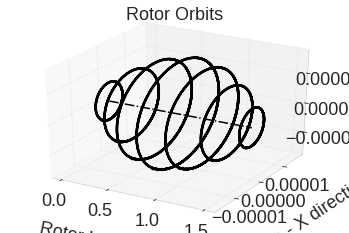

In [20]:
speed = 150.0
size = 1000
node = 3
t = np.linspace(0, 10, size)
F = np.zeros((size, rotor1.ndof))
F[:, 4 * node] = 10 * np.cos(2 * t)
F[:, 4 * node + 1] = 10 * np.sin(2 * t)
response = rotor1.run_orbit_response(speed, F, t)

# plot 3D graph - orbits for all nodes:
response.plot(plot_type="3d")

### Mode Shapes

You can also generate the plot for each mode shape.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f692812d490>)

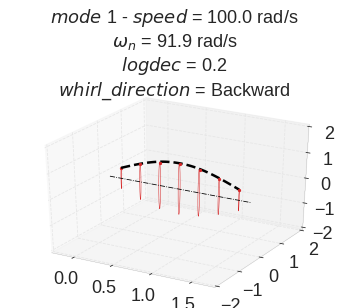

In [21]:
speed = 100.0
modes = rotor1.run_modal(speed)
modes.plot_mode(0)